In [2]:
# standard data manipulation libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Clustering models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


## DBSCAN Exploration Model

In [3]:
gap_notreg = pd.read_csv('./data/gap_notreg.csv')

In [4]:
gap_notreg.shape

(346762, 21)

### Create Spatial Dataframes
Create two dataframes, one to track the locations where AIS is turned on and the other to track the locations where AIS is turned off. Extract the lat and lon columns into a numpy matrix of coordinates. Then [convert the coordinates from degrees to radians](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/) in order to use scikit-learn's haversine metric.  
Remember:
- eps: max distance between points in order to be considered a cluster
- min_samples: minimum cluster size

In [5]:
# make a dataset of the AIS off locations

latlon_off = gap_notreg[['off_lat', 'off_lon']]
latlon_on = gap_notreg[['on_lat', 'on_lon']]

latlon_off.head()

,off_lat,off_lon
0,29.940583,122.278518
1,38.099993,13.543718
2,43.406192,-8.471367
3,26.573672,120.874392
4,44.675090,12.241697


In [6]:
latlon_on.head()

,on_lat,on_lon
0,29.938277,122.273638
1,38.088952,13.540445
2,43.354105,-8.375345
3,26.564128,120.902237
4,44.675367,12.235438


In [7]:
# convert columns to numpy matrices
off_coords = latlon_off.to_numpy()
on_coords = latlon_on.to_numpy()
off_coords

array([[ 29.94058333, 122.27851833],
       [ 38.09999333,  13.54371833],
       [ 43.40619167,  -8.47136667],
       ...,
       [ 24.60301833, 119.626755  ],
       [ 38.79213667, 121.40220333],
       [ 37.69489667, 121.143345  ]])

In [8]:
# convert epsilon and coordinates to radians since DBSCAN haversine 
# distance metric requires radian units 
# define epsilon as 1.5 kilometers and convert to radians (6371.0088 kms per radian)

epsilon = 20 / 6371.0088

off_coords = np.radians(off_coords)
on_coords = np.radians(on_coords)
off_coords

array([[ 0.52256176,  2.13416275],
       [ 0.66497033,  0.23638248],
       [ 0.75758096, -0.14785324],
       ...,
       [ 0.42940368,  2.08788075],
       [ 0.67705051,  2.11886817],
       [ 0.65790006,  2.11435024]])

## Cluster "Off" Coordinates

Explain why not scaling because in the same units.

In [10]:
# instantiate and fit
dbscan = DBSCAN(eps=epsilon, min_samples= 40, algorithm='ball_tree', metric='haversine')
dbscan.fit(off_coords)

DBSCAN(algorithm='ball_tree', eps=0.0031392202754452325, leaf_size=30,
       metric='haversine', metric_params=None, min_samples=40, n_jobs=None,
       p=None)

In [11]:
# check how many clusters were created #62474
len(set(dbscan.labels_))

294

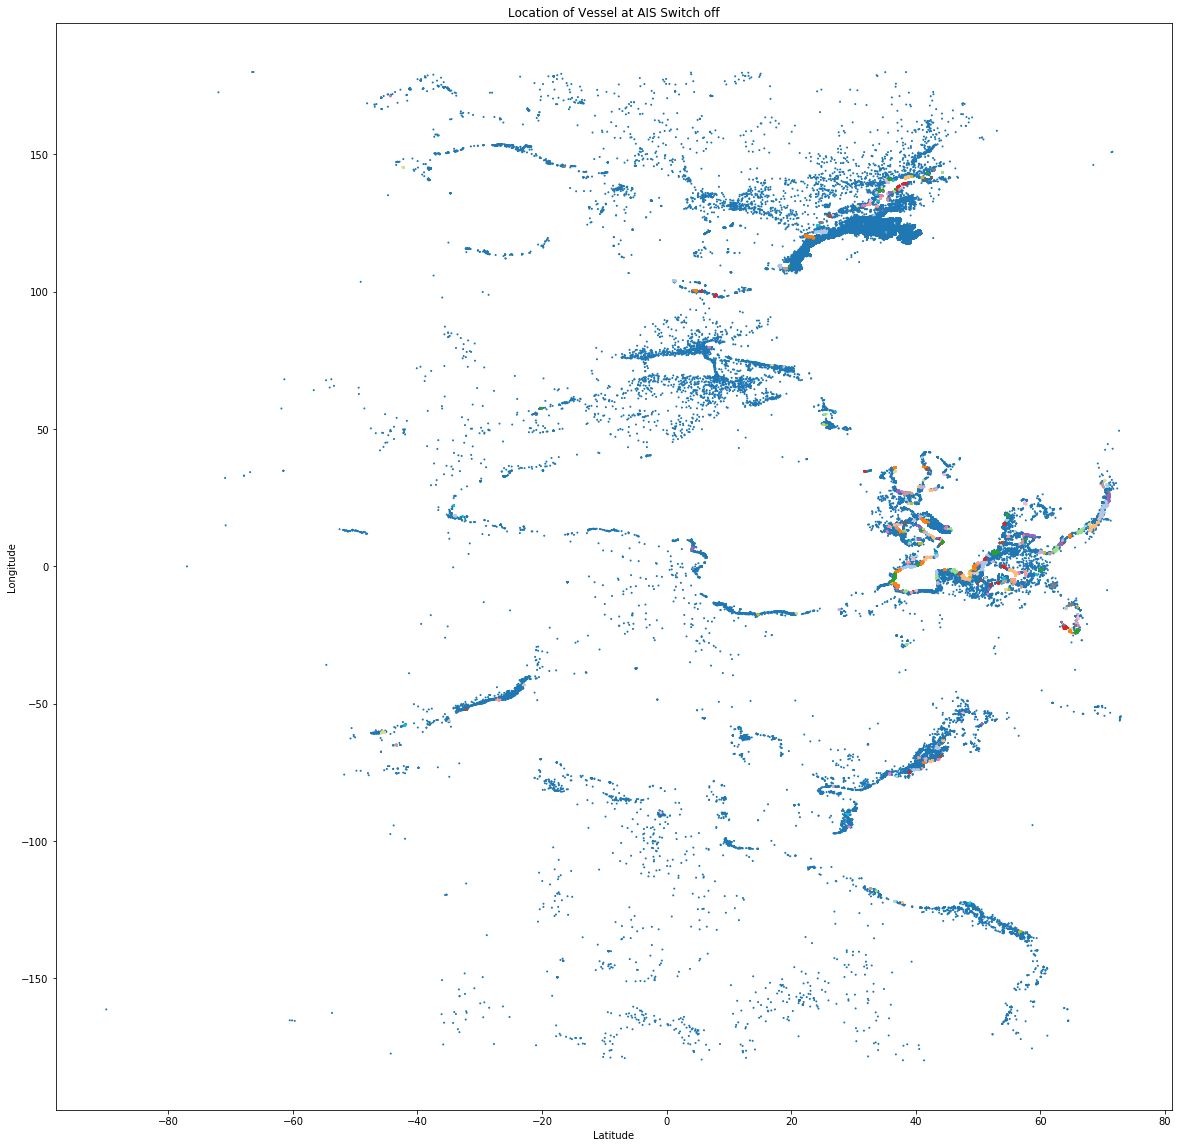

In [14]:
plt.figure(figsize=(20, 20))
plt.scatter(latlon_off['off_lat'], latlon_off['off_lon'], c=dbscan.labels_, s=1, cmap="tab20")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Location of Vessel at AIS Switch off');

In [17]:
# Create cluster column
latlon_off['cluster'] = dbscan.labels_
latlon_off.head()

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,off_lat,off_lon,cluster
0,29.940583,122.278518,0
1,38.099993,13.543718,1
2,43.406192,-8.471367,2
3,26.573672,120.874392,0
4,44.675090,12.241697,3


In [18]:
latlon_off.duplicated().sum()

642

In [15]:
# Which clusters have the most observations?
latlon_off['cluster'].value_counts()

 0      208866
-1       29219
 11      20215
 18       6635
 10       4873
         ...  
 259        40
 292        40
 291        36
 289        34
 287        27
Name: cluster, Length: 294, dtype: int64

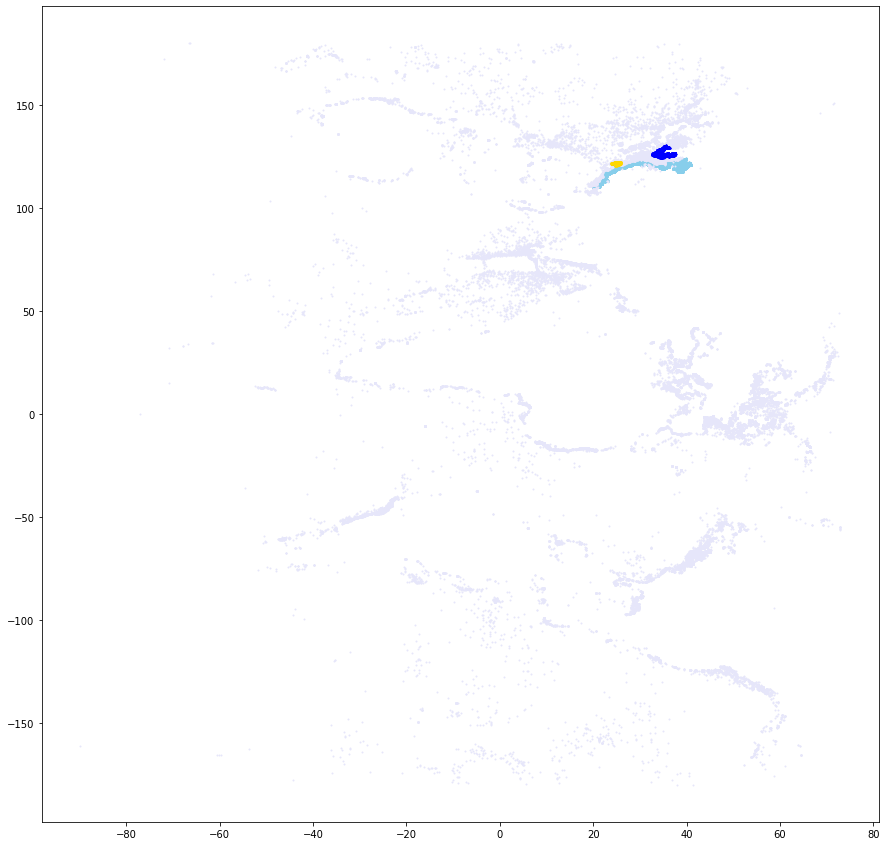

In [30]:
# Visualize the top 3 clusters and noise

cluster0 = latlon_off[latlon_off['cluster'] == 0]
cluster_1 = latlon_off[latlon_off['cluster'] == -1]
cluster11 = latlon_off[latlon_off['cluster'] == 11]
cluster18 = latlon_off[latlon_off['cluster'] == 18]

plt.figure(figsize=(15, 15))


plt.scatter(cluster0['off_lat'], cluster0['off_lon'], s=1, c='skyblue');
plt.scatter(cluster_1['off_lat'], cluster_1['off_lon'], s=1, c='lavender');
plt.scatter(cluster11['off_lat'], cluster11['off_lon'], s=1, c='b')
plt.scatter(cluster18['off_lat'], cluster18['off_lon'], s=1, c='gold');

In [44]:
# Merge the clusters into the original dataframe
gap_notreg = gap_notreg.merge(latlon_off, how='outer', left_index=True, right_index=True)
gap_notreg.head()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat_x,...,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m,off_lat_y,off_lon_y,cluster
0,412422839,39.433333,535.624620,0.007334,0.034917,fishing,CHN,2018-11-02T08:32:54Z,ab04ae1f-022d-1cf8-6704-79f5c18f03fe,29.940583,...,2018-11-03T23:59:40Z,d66f5755-1e80-50b7-9c24-97affcd0d30b,29.938277,122.273638,B,terrestrial,1000.0,29.940583,122.278518,0
1,247143160,80.800000,1260.751756,0.008425,2.947519,trawlers,ITA,2018-05-18T18:22:40Z,a08e856c-e011-5dab-8ae8-03a4bf0c7ba1,38.099993,...,2018-05-22T03:11:32Z,97e47f62-0784-5e70-bea4-b57c23dcab63,38.088952,13.540445,A,terrestrial,0.0,38.099993,13.543718,1
2,224231150,15.816667,9683.318918,0.330574,0.115448,set_gillnets,ESP,2018-03-22T11:28:05Z,b4fbb421-1944-5a5f-b3ae-aabb589bb8d3,43.406192,...,2018-03-23T03:17:34Z,7137847e-305e-5a4f-8b82-ab83b181c4ab,43.354105,-8.375345,B,terrestrial,1000.0,43.406192,-8.471367,2
3,413002111,14.433333,2965.614746,0.110945,0.416022,trawlers,CHN,2018-02-28T19:59:57Z,06e02215-e3b7-59ac-8504-f404fc25196c,26.573672,...,2018-03-01T10:26:32Z,499bb4b5-a209-5f79-9718-ea361000bbdc,26.564128,120.902237,A,terrestrial,44000.0,26.573672,120.874392,0
4,247074840,16.450000,495.809447,0.016275,0.538665,trawlers,ITA,2018-04-25T07:43:16Z,248c64e1-6d7b-5553-bffe-8974fc455332,44.675090,...,2018-04-26T00:10:43Z,5659fa33-6771-584a-95a5-4d35df3f544f,44.675367,12.235438,A,terrestrial,0.0,44.675090,12.241697,3


In [45]:
# Drop the additional lat/lon columns
gap_notreg.drop(columns=['off_lat_y', 'off_lon_y'], inplace=True)

In [47]:
# Rename columns
gap_notreg.rename(columns={'off_lat_x' : 'off_lat',
                           'off_lon_x' : 'off_lon',
                           'cluster' : 'off_cluster'})

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,off_receiver_type,off_distance_from_shore_m,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m,off_cluster
0,412422839,39.433333,535.624620,0.007334,0.034917,fishing,CHN,2018-11-02T08:32:54Z,ab04ae1f-022d-1cf8-6704-79f5c18f03fe,29.940583,...,terrestrial,0.0,2018-11-03T23:59:40Z,d66f5755-1e80-50b7-9c24-97affcd0d30b,29.938277,122.273638,B,terrestrial,1000.0,0
1,247143160,80.800000,1260.751756,0.008425,2.947519,trawlers,ITA,2018-05-18T18:22:40Z,a08e856c-e011-5dab-8ae8-03a4bf0c7ba1,38.099993,...,terrestrial,0.0,2018-05-22T03:11:32Z,97e47f62-0784-5e70-bea4-b57c23dcab63,38.088952,13.540445,A,terrestrial,0.0,1
2,224231150,15.816667,9683.318918,0.330574,0.115448,set_gillnets,ESP,2018-03-22T11:28:05Z,b4fbb421-1944-5a5f-b3ae-aabb589bb8d3,43.406192,...,terrestrial,3000.0,2018-03-23T03:17:34Z,7137847e-305e-5a4f-8b82-ab83b181c4ab,43.354105,-8.375345,B,terrestrial,1000.0,2
3,413002111,14.433333,2965.614746,0.110945,0.416022,trawlers,CHN,2018-02-28T19:59:57Z,06e02215-e3b7-59ac-8504-f404fc25196c,26.573672,...,terrestrial,42000.0,2018-03-01T10:26:32Z,499bb4b5-a209-5f79-9718-ea361000bbdc,26.564128,120.902237,A,terrestrial,44000.0,0
4,247074840,16.450000,495.809447,0.016275,0.538665,trawlers,ITA,2018-04-25T07:43:16Z,248c64e1-6d7b-5553-bffe-8974fc455332,44.675090,...,terrestrial,0.0,2018-04-26T00:10:43Z,5659fa33-6771-584a-95a5-4d35df3f544f,44.675367,12.235438,A,terrestrial,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346757,412330343,36.366667,759.867433,0.011282,180.878788,fishing,CHN,2019-11-06T07:40:18Z,f53b6c88-c3a0-b42a-ff20-bfefd905306b,35.452900,...,terrestrial,2000.0,2019-11-07T20:03:11Z,b5057f42-9fd1-9adc-7bf8-15bab43f061c,35.458812,119.600640,B,terrestrial,2000.0,0
346758,312366522,102.416667,9435.491271,0.049745,0.007645,fixed_gear,CHN,2018-12-12T00:54:53Z,54079cef-3918-5b42-be84-d6d3d43b6afe,34.483688,...,terrestrial,1000.0,2018-12-16T07:20:30Z,d831603a-0c38-5298-86c2-4c03180a8ec3,34.552417,119.855133,A,terrestrial,8000.0,0
346759,421255667,42.500000,62088.011607,0.788820,0.290867,trawlers,CHN,2018-09-21T15:39:25Z,2b8b00ea-3f70-5e3a-b787-48ace0b9b1ab,24.603018,...,terrestrial,45000.0,2018-09-23T10:10:24Z,509fe17e-4ec0-76a1-8a8f-2f1f8a58ce5c,24.582675,119.013088,B,terrestrial,31000.0,0
346760,413625297,41.100000,3141.256183,0.041269,0.021604,set_gillnets,CHN,2018-10-05T07:07:15Z,016a4319-a145-5b37-899b-427ab719351a,38.792137,...,terrestrial,3000.0,2018-10-07T00:14:01Z,e047197e-7b1a-5275-becf-4f91b9719df3,38.820360,121.400630,B,terrestrial,0.0,0


### References
- https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/